In [1]:
import os
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


import numpy as np
import tensorflow as tf
from keras.callbacks import TensorBoard
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
import keras
from keras import layers

from keras.layers import Input, Conv2D, Flatten, Dense, concatenate
from keras.models import Model

In [2]:
def open_pkl(file_name):
    #safe plane timeseg as pickle
    path = os.path.join(os.getcwd(), "dataset2")
    path_file = os.path.join(path, file_name)
    with open(path_file, "rb") as f:
        liste = pickle.load(f)
    return liste

X_vibfeature = open_pkl('X_vibfeature.pickle')
y_defectlabel = open_pkl('y_defectlabel.pickle')
c_context_raw = open_pkl('c_context_raw.pickle')

In [3]:
# convert list to numpy array
X = np.array(X_vibfeature)

# Reshape data into a 2D array
X_vibfeature_2d = X.reshape(X.shape[0], -1)  
X_vibfeature_2d[0]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on data and transform it
scaled_X_2d = scaler.fit_transform(X_vibfeature_2d)

# Reshape the scaled data back to its original shape
scaled_X = scaled_X_2d.reshape(X.shape)
scaled_X[0]

X_vib = scaled_X


# Convert the nested list into a numpy array
labels_array = np.array(c_context_raw)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert the string label to numerical label
labels_array[:, -1] = label_encoder.fit_transform(labels_array[:, -1])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your labels and transform them
c_context_scaled = scaler.fit_transform(labels_array)
c_context_scaled[0]

c_con = c_context_scaled



X_train, X_test, c_train, c_test, y_train, y_test = train_test_split(X_vib, c_con, y_defectlabel, test_size=0.3, random_state=42)


In [4]:
print(len(y_train))
print(X_train.shape)
print(c_train.shape)

print(len(y_test))
print(X_test.shape)
print(c_test.shape)

1360
(1360, 32, 128)
(1360, 7)
584
(584, 32, 128)
(584, 7)


In [5]:
c_test

array([[0.5, 1. , 1. , ..., 0. , 0. , 0. ],
       [0.5, 0. , 1. , ..., 0. , 0. , 0. ],
       [1. , 0. , 1. , ..., 0. , 0. , 0. ],
       ...,
       [0.5, 1. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.5, 1. , 0. , ..., 0. , 0. , 0. ]])

In [6]:
# Define input shapes for spectrogram data and context features
spectrogram_input = Input(shape=(32, 128, 1))
context_input = Input(shape=(7,))

# Convolutional layers for processing spectrogram data
conv_layer1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(spectrogram_input)
conv_layer2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(conv_layer1)
# Add more convolutional layers as needed

# Flatten the output of the convolutional layers
flatten_layer = Flatten()(conv_layer2)

# Concatenate the flattened convolutional output with context features
concatenated_features = concatenate([flatten_layer, context_input])

# Dense layers for further processing
dense_layer1 = Dense(128, activation='relu')(concatenated_features)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(dense_layer2)

# Define the model with inputs and output
model = Model(inputs=[spectrogram_input, context_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-04-01 14:26:44.718311: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-01 14:26:44.718465: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 30, 126, 32)  320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 124, 64)  18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 222208)       0           ['conv2d_1[0][0]']           

In [7]:
epochs = 50
model.fit([np.array(X_train), np.array(c_train)], np.array(y_train), epochs=epochs, validation_split=0.2)

Epoch 1/50


2024-04-01 14:26:46.069863: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-01 14:26:46.431012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be

33/34 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.6951

2024-04-01 14:26:51.783776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


34/34 [==============================] - 6s 52ms/step - loss: 0.6378 - accuracy: 0.6994 - val_loss: 0.2975 - val_accuracy: 0.8971
Epoch 2/50
 3/34 [=>............................] - ETA: 1s - loss: 0.2530 - accuracy: 0.8958

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x16x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x16x1x1xi1>'


34/34 [==============================] - 1s 36ms/step - loss: 0.2090 - accuracy: 0.9182 - val_loss: 0.1218 - val_accuracy: 0.9706
Epoch 3/50
34/34 [==============================] - 1s 38ms/step - loss: 0.0897 - accuracy: 0.9706 - val_loss: 0.2152 - val_accuracy: 0.9449
Epoch 4/50
34/34 [==============================] - 1s 40ms/step - loss: 0.0918 - accuracy: 0.9733 - val_loss: 0.1525 - val_accuracy: 0.9338
Epoch 5/50
34/34 [==============================] - 1s 36ms/step - loss: 0.0146 - accuracy: 0.9982 - val_loss: 0.0492 - val_accuracy: 0.9853
Epoch 6/50
34/34 [==============================] - 1s 36ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0574 - val_accuracy: 0.9853
Epoch 7/50
34/34 [==============================] - 1s 34ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0827 - val_accuracy: 0.9743
Epoch 8/50
34/34 [==============================] - 1s 35ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.9853
Epoch 9/50
34/34 [======

In [8]:
test_loss, test_accuracy = model.evaluate([np.array(X_test), np.array(c_test)], np.array(y_test))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 1s 42ms/step - loss: 0.0402 - accuracy: 0.9880
Test Loss: 0.040192801505327225
Test Accuracy: 0.9880136847496033


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x1xi1>'


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have predictions on the test set and true labels
predictions = model.predict([np.array(X_test), np.array(c_test)])
predictions_binary = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(classes))+0.5, labels=classes)
plt.yticks(ticks=np.arange(len(classes))+0.5, labels=classes)
plt.show()


ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

# ===========

In [9]:
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.models import Model

# Define input shape for the spectrogram data
spectrogram_input = Input(shape=(32, 128, 1))

# Convolutional layers for processing spectrogram data
conv_layer1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(spectrogram_input)
conv_layer2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(conv_layer1)
# Add more convolutional layers as needed

# Flatten the output of the convolutional layers
flatten_layer = Flatten()(conv_layer2)

# Dense layers for further processing
dense_layer1 = Dense(128, activation='relu')(flatten_layer)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(dense_layer2)

# Define the model with input and output
model_no_context = Model(inputs=spectrogram_input, outputs=output_layer)

# Compile the model
model_no_context.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model_no_context.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 126, 32)       320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 124, 64)       18496     
                                                                 
 flatten_1 (Flatten)         (None, 222208)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               28442752  
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65  

In [10]:
epochs = 50
model_no_context.fit(np.array(X_train), np.array(y_train), epochs=epochs, validation_split=0.2)

Epoch 1/50


2024-04-01 14:27:53.926111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc

33/34 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.6477

2024-04-01 14:27:55.344756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


34/34 [==============================] - 2s 42ms/step - loss: 0.6379 - accuracy: 0.6517 - val_loss: 0.3727 - val_accuracy: 0.8750
Epoch 2/50
 5/34 [===>..........................] - ETA: 0s - loss: 0.3627 - accuracy: 0.8750

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x16x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x16x1x1xi1>'


34/34 [==============================] - 1s 35ms/step - loss: 0.2023 - accuracy: 0.9256 - val_loss: 0.1006 - val_accuracy: 0.9632
Epoch 3/50
34/34 [==============================] - 1s 35ms/step - loss: 0.0747 - accuracy: 0.9733 - val_loss: 0.1861 - val_accuracy: 0.9449
Epoch 4/50
34/34 [==============================] - 1s 35ms/step - loss: 0.0492 - accuracy: 0.9881 - val_loss: 0.0539 - val_accuracy: 0.9779
Epoch 5/50
34/34 [==============================] - 1s 35ms/step - loss: 0.0135 - accuracy: 0.9972 - val_loss: 0.0777 - val_accuracy: 0.9743
Epoch 6/50
34/34 [==============================] - 1s 35ms/step - loss: 0.0106 - accuracy: 0.9972 - val_loss: 0.0585 - val_accuracy: 0.9816
Epoch 7/50
34/34 [==============================] - 1s 33ms/step - loss: 0.0167 - accuracy: 0.9954 - val_loss: 0.1396 - val_accuracy: 0.9522
Epoch 8/50
34/34 [==============================] - 1s 33ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0560 - val_accuracy: 0.9816
Epoch 9/50
34/34 [======

In [11]:
test_loss, test_accuracy = model_no_context.evaluate(np.array(X_test), np.array(y_test))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 [==============================] - 1s 34ms/step - loss: 0.1424 - accuracy: 0.9692
Test Loss: 0.14239637553691864
Test Accuracy: 0.9691780805587769


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x8x1x1xi1>'


# ==========

In [12]:
test_loss, test_accuracy = model.evaluate([np.array(X_test), np.array(c_test)], np.array(y_test))


19/19 [==============================] - 0s 15ms/step - loss: 0.0402 - accuracy: 0.9880


In [13]:
np.array(X_test).shape, np.array(y_test).shape

((584, 32, 128), (584,))

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

labels_test = y_test

# Assuming you have predictions on the test set
predictions = model.predict([np.array(X_test), np.array(c_test)])
predictions_binary = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute accuracy
accuracy = accuracy_score(labels_test, predictions_binary)

# Compute precision, recall, and F1-score
precision = precision_score(labels_test, predictions_binary)
recall = recall_score(labels_test, predictions_binary)
f1 = f1_score(labels_test, predictions_binary)

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_test, predictions_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)


19/19 [==============================] - 1s 40ms/step
Accuracy: 0.988013698630137
Precision: 0.9929078014184397
Recall: 0.9824561403508771
F1-score: 0.9876543209876543
Confusion Matrix:
[[297   2]
 [  5 280]]


In [21]:
predictions

array([[2.92149622e-07],
       [2.65321761e-01],
       [8.72555120e-06],
       [1.62640845e-05],
       [1.00000000e+00],
       [8.34747667e-08],
       [1.00000000e+00],
       [1.20242692e-06],
       [9.99999881e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [5.06863444e-07],
       [9.99999404e-01],
       [1.00000000e+00],
       [2.07410866e-09],
       [1.00000000e+00],
       [1.00000000e+00],
       [5.87033816e-02],
       [6.18693222e-11],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99999881e-01],
       [1.00000000e+00],
       [7.36165049e-08],
       [8.97468883e-04],
       [9.99999881e-01],
       [1.00000000e+00],
       [4.33171226e-04],
       [2.88916535e-09],
       [1.21296836e-07],
       [2.80883560e-05],
       [3.54921035e-08],
       [9.97146547e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.60640514e-08],
       [1.00000000e+00],
       [1.00000000e+00],


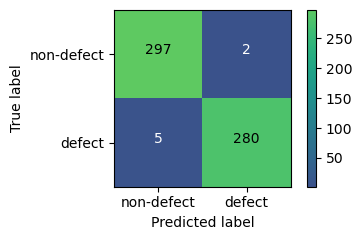

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define the part of the colormap you want to use
start_color = 0.25  # Start color index
end_color = 0.75    # End color index

# Create a subset of the 'viridis' colormap
viridis_subset = plt.cm.viridis(np.linspace(start_color, end_color, 256))

# Create a ListedColormap using the subset
viridis_subset_cmap = ListedColormap(viridis_subset)

conf_matrix = np.array([[297, 2],
                        [5, 280]])

plt.figure(figsize=(4, 2.5))  # Adjust the figure size here


plt.imshow(conf_matrix, interpolation='nearest', cmap=viridis_subset_cmap)
plt.colorbar()

classes = ['non-defect', 'defect']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="black" if conf_matrix[i, j] > thresh else "white")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.pdf')
plt.show()
